**Секція 1. Логістична регресія з нуля.**

Будемо крок за кроком будувати модель лог регресії з нуля для передбачення, чи буде врожай більше за 80 яблук (задача подібна до лекційної, але на класифікацію).

Давайте нагадаємо основні формули для логістичної регресії.

### Функція гіпотези - обчислення передбачення у логістичній регресії:

$$
\hat{y} = \sigma(x W^T + b) = \frac{1}{1 + e^{-(x W^T + b)}}
$$

Де:
- $ \hat{y} $ — це ймовірність "позитивного" класу.
- $ x $ — це вектор (або матриця для набору прикладів) вхідних даних.
- $ W $ — це вектор (або матриця) вагових коефіцієнтів моделі.
- $ b $ — це зміщення (bias).
- $ \sigma(z) $ — це сигмоїдна функція активації.

### Як обчислюється сигмоїдна функція:

Сигмоїдна функція $ \sigma(z) $ має вигляд:

$$
\sigma(z) = \frac{1}{1 + e^{-z}}
$$

Ця функція перетворює будь-яке дійсне значення $ z $ в інтервал від 0 до 1, що дозволяє інтерпретувати вихід як ймовірність для логістичної регресії.

### Формула функції втрат для логістичної регресії (бінарна крос-ентропія):

Функція втрат крос-ентропії оцінює, наскільки добре модель передбачає класи, порівнюючи передбачені ймовірності $ \hat{y} $ із справжніми мітками $ y $. Формула наступна:

$$
L(y, \hat{y}) = - \left[ y \cdot \log(\hat{y}) + (1 - y) \cdot \log(1 - \hat{y}) \right]
$$

Де:
- $ y $ — це справжнє значення (мітка класу, 0 або 1).
- $ \hat{y} $ — це передбачене значення (ймовірність).



1.
Тут вже наведений код для ініціювання набору даних в форматі numpy. Перетворіть `inputs`, `targets` на `torch` тензори. Виведіть результат на екран.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

/home/liubov/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
# Вхідні дані (temp, rainfall, humidity)
inputs = np.array([[73, 67, 43],
                   [91, 88, 64],
                   [87, 134, 58],
                   [102, 43, 37],
                   [69, 96, 70]], dtype='float32')

# Таргети (apples > 80)
targets = np.array([[0],
                    [1],
                    [1],
                    [0],
                    [1]], dtype='float32')

In [3]:
inputs_tensor = torch.from_numpy(inputs)
targets_tensor = torch.from_numpy(targets)

print("Inputs Tensor:\n", inputs_tensor)
print("Targets Tensor:\n", targets_tensor)

Inputs Tensor:
 tensor([[ 73.,  67.,  43.],
        [ 91.,  88.,  64.],
        [ 87., 134.,  58.],
        [102.,  43.,  37.],
        [ 69.,  96.,  70.]])
Targets Tensor:
 tensor([[0.],
        [1.],
        [1.],
        [0.],
        [1.]])


2. Ініціюйте ваги `w`, `b` для моделі логістичної регресії потрібної форми зважаючи на розмірності даних випадковими значеннями з нормального розподілу. Лишаю тут код для фіксації `random_seed`.

In [4]:
torch.random.manual_seed(1)

In [5]:
n_features = 3  # temp, rainfall, humidity

# Ініціалізація ваг 
w = torch.randn(n_features, 1, dtype=torch.float32)
b = torch.randn(1, dtype=torch.float32)

print("Weights (w):\n", w)
print("Bias (b):\n", b)

Weights (w):
 tensor([[0.6614],
        [0.2669],
        [0.0617]])
Bias (b):
 tensor([0.6213])


3. Напишіть функцію `model`, яка буде обчислювати функцію гіпотези в логістичній регресії і дозволяти робити передбачення на основі введеного рядка даних і коефіцієнтів в змінних `w`, `b`.

  **Важливий момент**, що функція `model` робить обчислення на `torch.tensors`, тож для математичних обчислень використовуємо фукнціонал `torch`, наприклад:
  - обчсилення $e^x$: `torch.exp(x)`
  - обчсилення $log(x)$: `torch.log(x)`
  - обчислення середнього значення вектору `x`: `torch.mean(x)`

  Використайте функцію `model` для обчислення передбачень з поточними значеннями `w`, `b`.Виведіть результат обчислень на екран.

  Проаналізуйте передбачення. Чи не викликають вони у вас підозр? І якщо викликають, то чим це може бути зумовлено?

In [6]:
def model(X, w, b):
    z = torch.matmul(X, w) + b        
    y_pred = 1 / (1 + torch.exp(-z))  
    return y_pred

predictions = model(inputs_tensor, w, b)
predictions


tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]])

Всі передбачення рівні 1.0. Це означає, що при поточних випадково ініціалізованих w і b модель дає дуже великі значення лінійної комбінації z=Xw+b, через що сигмоїдна функція фактично «засіла» у верхній асимптоті (1).

Модель ще не навчена, і тому передбачає лише один клас. Це нормально на етапі ініціалізації. Для отримання коректних передбачень потрібно навчати модель, підбираючи w і b методом градієнтного спуску на основі функції втрат.

4. Напишіть функцію `binary_cross_entropy`, яка приймає на вхід передбачення моделі `predicted_probs` та справжні мітки в даних `true_labels` і обчислює значення втрат (loss)  за формулою бінарної крос-ентропії для кожного екземпляра та вертає середні втрати по всьому набору даних.
  Використайте функцію `binary_cross_entropy` для обчислення втрат для поточних передбачень моделі.

In [7]:
def binary_cross_entropy(predicted_probs, true_labels):
    # Щоб уникнути log(0), додаємо невелике epsilon
    epsilon = 1e-7
    predicted_probs = torch.clamp(predicted_probs, epsilon, 1 - epsilon)
    
    # Бінарна крос-ентропія
    loss_per_sample = - (true_labels * torch.log(predicted_probs) + 
                         (1 - true_labels) * torch.log(1 - predicted_probs))
    
    
    return torch.mean(loss_per_sample) # Середнє по всьому набору

loss = binary_cross_entropy(predictions, targets_tensor)
print("Binary Cross-Entropy Loss:", loss.item())

Binary Cross-Entropy Loss: 6.376954078674316


5. Зробіть зворотнє поширення помилки і виведіть градієнти за параметрами `w`, `b`. Проаналізуйте їх значення. Як гадаєте, чому вони саме такі?

In [8]:
w = w.clone().detach().requires_grad_(True)
b = b.clone().detach().requires_grad_(True)

predictions = model(inputs_tensor, w, b)
loss = binary_cross_entropy(predictions, targets_tensor)

loss.backward()
print("Gradients for w:\n", w.grad)
print("Gradients for b:\n", b.grad)

Gradients for w:
 tensor([[0.],
        [0.],
        [0.]])
Gradients for b:
 tensor([0.])


Поточні w і b занадто великі для чисельного обчислення, тому модель «застрягла» у стані saturate.

Щоб градієнти були адекватними, треба ініціалізувати ваги меншими значеннями, або використовувати стабілізовану реалізацію BCE, наприклад torch.nn.BCEWithLogitsLoss, яка обчислює BCE без прямої сигмоїди (чисельно стійко).

**Що сталось?**

В цій задачі, коли ми ініціювали значення випадковими значеннями з нормального розподілу, насправді ці значення не були дуже гарними стартовими значеннями і привели до того, що градієнти стали дуже малими або навіть рівними нулю (це призводить до того, що градієнти "зникають"), і відповідно при оновленні ваг у нас не буде нічого змінюватись. Це називається `gradient vanishing`. Це відбувається через **насичення сигмоїдної функції активації.**

У нашій задачі ми використовуємо сигмоїдну функцію активації, яка має такий вигляд:

   $$
   \sigma(z) = \frac{1}{1 + e^{-z}}
   $$


Коли значення $z$ дуже велике або дуже мале, сигмоїдна функція починає "насичуватись". Це означає, що для великих позитивних $z$ сигмоїда наближається до 1, а для великих негативних — до 0. В цих діапазонах градієнти починають стрімко зменшуватись і наближаються до нуля (бо градієнт - це похідна, похідна на проміжку функції, де вона паралельна осі ОХ, дорівнює 0), що робить оновлення ваг неможливим.

![](https://editor.analyticsvidhya.com/uploads/27889vaegp.png)

У логістичній регресії $ z = x \cdot w + b $. Якщо ваги $w, b$ - великі, значення $z$ також буде великим, і сигмоїда перейде в насичену область, де градієнти дуже малі.

Саме це сталося в нашій задачі, де великі випадкові значення ваг викликали насичення сигмоїдної функції. Це в свою чергу призводить до того, що під час зворотного поширення помилки (backpropagation) модель оновлює ваги дуже повільно або зовсім не оновлює. Це називається проблемою **зникнення градієнтів** (gradient vanishing problem).

**Що ж робити?**
Ініціювати ваги маленькими значеннями навколо нуля. Наприклад ми можемо просто в існуючій ініціалізації ваги розділити на 1000. Можна також використати інший спосіб ініціалізації вагів - інформація про це [тут](https://www.geeksforgeeks.org/initialize-weights-in-pytorch/).

Як це робити - показую нижче. **Виконайте код та знову обчисліть передбачення, лосс і виведіть градієнти.**

А я пишу пояснення, чому просто не зробити

```
w = torch.randn(1, 3, requires_grad=True)/1000
b = torch.randn(1, requires_grad=True)/1000
```

Нам потрібно, аби тензори вагів були листовими (leaf tensors).

1. **Що таке листовий тензор**
Листовий тензор — це тензор, який був створений користувачем безпосередньо і з якого починається обчислювальний граф. Якщо такий тензор має `requires_grad=True`, PyTorch буде відслідковувати всі операції, виконані над ним, щоб правильно обчислювати градієнти під час навчання.

2. **Чому ми використовуємо `w.data` замість звичайних операцій**
Якщо ми просто виконали б операції, такі як `(w - 0.5) / 100`, ми б отримали **новий тензор**, який вже не був би листовим тензором, оскільки ці операції створюють **новий** тензор, а не модифікують існуючий.

  Проте, щоб залишити наші тензори ваги `w` та зміщення `b` листовими і продовжити можливість відстеження градієнтів під час тренування, ми використовуємо атрибут `.data`. Цей атрибут дозволяє **виконувати операції in-place (прямо на існуючому тензорі)** без зміни самого об'єкта тензора. Отже, тензор залишається листовим, і PyTorch може коректно обчислювати його градієнти.

3. **Чому важливо залишити тензор листовим**
Якщо тензор більше не є листовим (наприклад, через проведення операцій, що створюють нові тензори), ви не зможете отримати градієнти за допомогою `w.grad` чи `b.grad` після виклику `loss.backward()`. Це може призвести до втрати можливості оновлення параметрів під час тренування моделі. В нашому випадку ми хочемо, щоб тензори `w` та `b` накопичували градієнти, тому вони повинні залишатись листовими.

**Висновок:**
Ми використовуємо `.data`, щоб виконати операції зміни значень на ваги і зміщення **in-place**, залишаючи їх листовими тензорами, які можуть накопичувати градієнти під час навчання. Це дозволяє коректно працювати механізму зворотного поширення помилки (backpropagation) і оновлювати ваги моделі.

5. Виконайте код та знову обчисліть передбачення, лосс і знайдіть градієнти та виведіть всі ці тензори на екран.

In [9]:
torch.random.manual_seed(1)
w = torch.randn(1, 3, requires_grad=True)  # Листовий тензор
b = torch.randn(1, requires_grad=True)     # Листовий тензор

# in-place операції
w.data = w.data / 1000
b.data = b.data / 1000

In [10]:
def model(X, w, b):
    z = torch.matmul(X, w.t()) + b  # Транспонуємо w, бо у нас (1,3)
    return 1 / (1 + torch.exp(-z))

# Передбачення
predictions = model(inputs_tensor, w, b)

# Функція бінарної крос-ентропії
def binary_cross_entropy(predicted_probs, true_labels):
    epsilon = 1e-7
    predicted_probs = torch.clamp(predicted_probs, epsilon, 1 - epsilon)
    loss_per_sample = - (true_labels * torch.log(predicted_probs) + 
                         (1 - true_labels) * torch.log(1 - predicted_probs))
    return torch.mean(loss_per_sample)

# Втрати
loss = binary_cross_entropy(predictions, targets_tensor)

# Зворотнє поширення
loss.backward()

# Вивід результатів
print("Predictions:\n", predictions)
print("Binary Cross-Entropy Loss:", loss.item())
print("Gradients for w:\n", w.grad)
print("Gradients for b:\n", b.grad)

Predictions:
 tensor([[0.5174],
        [0.5220],
        [0.5244],
        [0.5204],
        [0.5190]], grad_fn=<MulBackward0>)
Binary Cross-Entropy Loss: 0.6829456686973572
Gradients for w:
 tensor([[ -5.4417, -18.9853, -10.0682]])
Gradients for b:
 tensor([-0.0794])


- Всі передбачення > 0.5, що логічно з урахуванням маленьких ваг і зміщення — модель ще не навчена, тому не розрізняє класи. Значення тепер ближчі до ймовірностей, а не «застрягли» на 1.
- Втрати тепер помірні, близькі до ln(2) ≈ 0.693, що очікувано для випадкових передбачень у задачі бінарної класифікації. Це значення набагато менше, ніж раніше (~6.38).
- Загалом, градієнти спрямовані так, щоб модель почала «розрізняти» класи.

6. Напишіть алгоритм градієнтного спуску, який буде навчати модель з використанням написаних раніше функцій і виконуючи оновлення ваг. Алгоритм має включати наступні кроки:

  1. Генерація прогнозів
  2. Обчислення втрат
  3. Обчислення градієнтів (gradients) loss-фукнції відносно ваг і зсувів
  4. Налаштування ваг шляхом віднімання невеликої величини, пропорційної градієнту (`learning_rate` домножений на градієнт)
  5. Скидання градієнтів на нуль

Виконайте градієнтний спуск протягом 1000 епох, обчисліть фінальні передбачення і проаналізуйте, чи вони точні?

In [11]:
learning_rate = 0.01
epochs = 1000

for epoch in range(epochs):
    # 1. Прогноз
    predictions = model(inputs_tensor, w, b)
    
    # 2. Втрати
    loss = binary_cross_entropy(predictions, targets_tensor)
    
    # 3. Зворотнє поширення
    loss.backward()
    
    # 4. Оновлення ваг (in-place)
    with torch.no_grad():
        w -= learning_rate * w.grad
        b -= learning_rate * b.grad
    
    # 5. Скидання градієнтів
    w.grad.zero_()
    b.grad.zero_()

final_predictions = model(inputs_tensor, w, b)
predicted_classes = (final_predictions >= 0.5).float()

print("Final Predictions (Probabilities):\n", final_predictions)
print("Predicted Classes:\n", predicted_classes)
print("True Labels:\n", targets_tensor)


Final Predictions (Probabilities):
 tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], grad_fn=<MulBackward0>)
Predicted Classes:
 tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]])
True Labels:
 tensor([[0.],
        [1.],
        [1.],
        [0.],
        [1.]])


**Секція 2. Створення лог регресії з використанням функціоналу `torch.nn`.**

Давайте повторно реалізуємо ту ж модель, використовуючи деякі вбудовані функції та класи з PyTorch.

Даних у нас буде побільше - тож, визначаємо нові масиви.

In [12]:
# Вхідні дані (temp, rainfall, humidity)
inputs = np.array([[73, 67, 43],
                   [91, 88, 64],
                   [87, 134, 58],
                   [102, 43, 37],
                   [69, 96, 70],
                   [73, 67, 43],
                   [91, 88, 64],
                   [87, 134, 58],
                   [102, 43, 37],
                   [69, 96, 70],
                   [73, 67, 43],
                   [91, 88, 64],
                   [87, 134, 58],
                   [102, 43, 37],
                   [69, 96, 70]], dtype='float32')

# Таргети (apples > 80)
targets = np.array([[0],
                    [1],
                    [1],
                    [0],
                    [1],
                    [0],
                    [1],
                    [1],
                    [0],
                    [1],
                    [0],
                    [1],
                    [1],
                    [0],
                    [1]], dtype='float32')

In [13]:
inputs_tensor = torch.from_numpy(inputs)
targets_tensor = torch.from_numpy(targets)

print("Inputs Tensor:\n", inputs_tensor)
print("Targets Tensor:\n", targets_tensor)

Inputs Tensor:
 tensor([[ 73.,  67.,  43.],
        [ 91.,  88.,  64.],
        [ 87., 134.,  58.],
        [102.,  43.,  37.],
        [ 69.,  96.,  70.],
        [ 73.,  67.,  43.],
        [ 91.,  88.,  64.],
        [ 87., 134.,  58.],
        [102.,  43.,  37.],
        [ 69.,  96.,  70.],
        [ 73.,  67.,  43.],
        [ 91.,  88.,  64.],
        [ 87., 134.,  58.],
        [102.,  43.,  37.],
        [ 69.,  96.,  70.]])
Targets Tensor:
 tensor([[0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.]])


7. Завантажте вхідні дані та мітки в PyTorch тензори та з них створіть датасет, який поєднує вхідні дані з мітками, використовуючи клас `TensorDataset`. Виведіть перші 3 елементи в датасеті.



In [14]:
dataset = TensorDataset(inputs_tensor, targets_tensor)
for i in range(3):
    print(f"Element {i}:")
    print("  Input:", dataset[i][0])
    print("  Target:", dataset[i][1])

Element 0:
  Input: tensor([73., 67., 43.])
  Target: tensor([0.])
Element 1:
  Input: tensor([91., 88., 64.])
  Target: tensor([1.])
Element 2:
  Input: tensor([ 87., 134.,  58.])
  Target: tensor([1.])


8. Визначте data loader з класом **DataLoader** для підготовленого датасету `train_ds`, встановіть розмір батчу на 5 та увімкніть перемішування даних для ефективного навчання моделі. Виведіть перший елемент в дата лоадері.

In [15]:
train_dl = DataLoader(dataset, batch_size=5, shuffle=True)
first_batch = next(iter(train_dl))

print("Inputs batch:\n", first_batch[0])
print("\nTargets batch:\n", first_batch[1])

Inputs batch:
 tensor([[ 73.,  67.,  43.],
        [ 91.,  88.,  64.],
        [102.,  43.,  37.],
        [ 69.,  96.,  70.],
        [102.,  43.,  37.]])

Targets batch:
 tensor([[0.],
        [1.],
        [0.],
        [1.],
        [0.]])


9. Створіть клас `LogReg` для логістичної регресії, наслідуючи модуль `torch.nn.Module` за прикладом в лекції (в частині про FeedForward мережі).

  У нас модель складається з лінійної комбінації вхідних значень і застосування фукнції сигмоїда. Тож, нейромережа буде складатись з лінійного шару `nn.Linear` і використання активації `nn.Sigmid`. У створеному класі мають бути реалізовані методи `__init__` з ініціалізацією шарів і метод `forward` для виконання прямого проходу моделі через лінійний шар і функцію активації.

  Створіть екземпляр класу `LogReg` в змінній `model`.

In [16]:
class LogReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(3, 1) # Лінійний шар: 3 входи → 1 вихід
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.linear(x)      
        out = self.sigmoid(out)   
        return out

model = LogReg()
model

LogReg(
  (linear): Linear(in_features=3, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

10. Задайте оптимізатор `Stockastic Gradient Descent` в змінній `opt` для навчання моделі логістичної регресії. А також визначіть в змінній `loss` функцію втрат `binary_cross_entropy` з модуля `torch.nn.functional` для обчислення втрат моделі. Обчисліть втрати для поточних передбачень і міток, а потім виведіть їх. Зробіть висновок, чи моделі вдалось навчитись?

In [17]:
opt = SGD(model.parameters(), lr=0.01)
loss = F.binary_cross_entropy
preds = model(inputs_tensor)
loss_value = loss(preds, targets_tensor)

print("Predictions:\n", preds)
print("\nLoss:", loss_value.item())

Predictions:
 tensor([[1.7603e-01],
        [3.3674e-02],
        [6.1762e-07],
        [9.9996e-01],
        [4.3257e-05],
        [1.7603e-01],
        [3.3674e-02],
        [6.1762e-07],
        [9.9996e-01],
        [4.3257e-05],
        [1.7603e-01],
        [3.3674e-02],
        [6.1762e-07],
        [9.9996e-01],
        [4.3257e-05]], grad_fn=<SigmoidBackward0>)

Loss: 7.631152629852295


- Вони непогано відокремлюють класи, але не ідеально.
- Значення втрат 7.63 - дуже велике значення.
- Ні. Модель ще не навчена.

11. Візьміть з лекції функцію для тренування моделі з відстеженням значень втрат і навчіть щойно визначену модель на 1000 епохах. Виведіть після цього графік зміни loss, фінальні передбачення і значення таргетів.

In [18]:
# Визначаэмо функцію для навчання моделі
def fit(num_epochs, model, loss_fn, opt, train_dl):
    for epoch in range(num_epochs):
        for xb,yb in train_dl:
            # Створення передбачень
            pred = model(xb)
            loss = loss_fn(pred, yb)

            # Виконання градієнтного спуску
            loss.backward()
            opt.step()
            opt.zero_grad()
    print('Training loss: ', loss_fn(model(inputs), targets))

# Модифікована функцію fit для відстеження втрат
def fit_return_loss(num_epochs, model, loss_fn, opt, train_dl):
    losses = []
    for epoch in range(num_epochs):
        # Ініціалізуємо акумулятор для втрат
        total_loss = 0

        for xb, yb in train_dl:
            # Генеруємо передбачення
            pred = model(xb)

            # Обчислюємо втрати
            loss = loss_fn(pred, yb)

            # Виконуємо градієнтний спуск
            loss.backward()
            opt.step()
            opt.zero_grad()

            # Накопичуємо втрати
            total_loss += loss.item()

        # Обчислюємо середні втрати для епохи
        avg_loss = total_loss / len(train_dl)
        losses.append(avg_loss)

        # Виводимо підсумок епохи
        if (epoch + 1) % 10 == 0:
          print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
    return losses

In [23]:
opt = torch.optim.SGD(model.parameters(), 1e-5)
loss_fn = F.mse_loss
loss = fit_return_loss(1000, model, loss_fn, opt, train_dl)

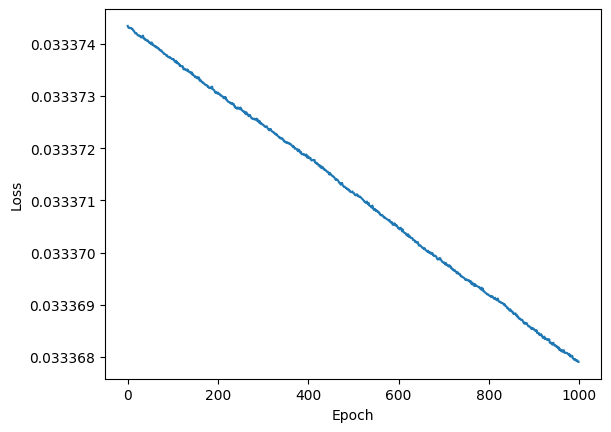

In [24]:
plt.plot(loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

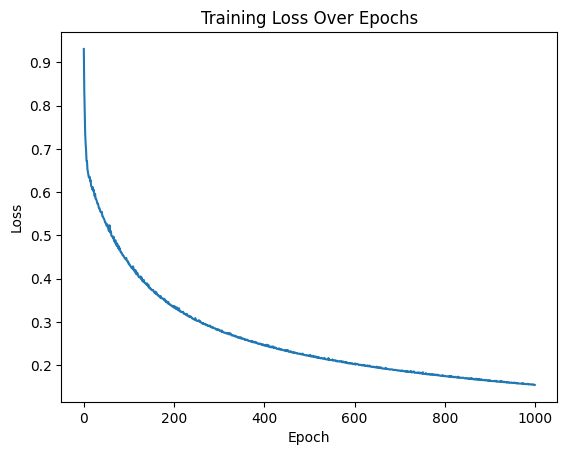

Final predictions:
 tensor([[0.3309],
        [0.7718],
        [0.9875],
        [0.0297],
        [0.9345],
        [0.3309],
        [0.7718],
        [0.9875],
        [0.0297],
        [0.9345],
        [0.3309],
        [0.7718],
        [0.9875],
        [0.0297],
        [0.9345]])

True targets:
 tensor([[0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.]])


In [22]:

# --- Data ---
inputs = np.array([[73, 67, 43],
                   [91, 88, 64],
                   [87, 134, 58],
                   [102, 43, 37],
                   [69, 96, 70],
                   [73, 67, 43],
                   [91, 88, 64],
                   [87, 134, 58],
                   [102, 43, 37],
                   [69, 96, 70],
                   [73, 67, 43],
                   [91, 88, 64],
                   [87, 134, 58],
                   [102, 43, 37],
                   [69, 96, 70]], dtype='float32')

targets = np.array([[0],[1],[1],[0],[1],
                    [0],[1],[1],[0],[1],
                    [0],[1],[1],[0],[1]], dtype='float32')

# --- Scale inputs (VERY important for logistic regression) ---
inputs = inputs / 100

inputs_tensor = torch.from_numpy(inputs)
targets_tensor = torch.from_numpy(targets)

train_ds = TensorDataset(inputs_tensor, targets_tensor)
train_dl = DataLoader(train_ds, batch_size=5, shuffle=True)

# --- Model ---
class LogReg(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(3, 1)
        self.sigmoid = nn.Sigmoid()
    def forward(self, x):
        return self.sigmoid(self.linear(x))

model = LogReg()

# --- Optimizer ---
opt = SGD(model.parameters(), lr=0.1)
loss_fn = F.binary_cross_entropy


# --- Training with loss tracking ---
def fit_return_loss(num_epochs, model, loss_fn, opt, train_dl):
    losses = []
    for epoch in range(num_epochs):
        total_loss = 0

        for xb, yb in train_dl:
            pred = model(xb)
            loss = loss_fn(pred, yb)

            loss.backward()
            opt.step()
            opt.zero_grad()

            total_loss += loss.item()

        losses.append(total_loss / len(train_dl))

    return losses


# --- Train ---
losses = fit_return_loss(1000, model, loss_fn, opt, train_dl)

# --- Plot losses ---
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.show()

# --- Final predictions ---
final_preds = model(inputs_tensor).detach()
print("Final predictions:\n", final_preds)

print("\nTrue targets:\n", targets_tensor)
